In [1]:
from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.image.vol import filter_flat, unfilter_flat
from fish.util.fileio import read_image
from skimage.transform import resize, downscale_local_mean
from skimage.exposure import rescale_intensity
from skimage.io import imsave
from scipy.io import loadmat
from fish.util.plot import proj_fuse
from glob import glob
import matplotlib.pyplot as plt
plt.style.use('npg')
%matplotlib inline
import numpy as np

In [2]:
def my_proj(data, fun, aspect):
    from skimage.transform import resize
    from numpy import zeros, array
    # project over z and y
    old_dims = array(data.shape)
    new_dims = array(aspect) * old_dims
    proj_axes = [0,1]    
    projs = []
    for axis, dim in enumerate(new_dims[:2]):
        indexer = list(range(len(new_dims)))
        indexer.pop(axis)
        projs.append(resize(fun(data, axis), new_dims[indexer], mode='constant', preserve_range=True))
    
    output = zeros([new_dims[0] + new_dims[1], new_dims[2]])
    output[:new_dims[0]] = projs[1]
    output[new_dims[0]:] = projs[0]
    
    return output
    

def trigger_data(triggers, window, fnames, average=False, parallelism=None):
    from fish.util.fileio import read_images, read_image    
    from numpy import array, zeros
    
    sample = read_image(fnames[0])

    if average:
        dims = list(sample.shape)
        dims.insert(0, len(window))
        ims_trial = zeros(dims)
    else: 
        dims = list(sample.shape)
        dims.insert(0, len(window))
        dims.insert(0, len(triggers))
        ims_trial = zeros(dims)
    
    for ind, trig in enumerate(triggers):        
        tr = read_images(array(fnames)[trig + window], parallelism)
        
        if average:
            ims_trial += tr.astype('float32')/len(triggers)

        else:
            ims_trial[ind] = tr
    
    return ims_trial

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

In [3]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/']

In [284]:
import sys
import json
import pathlib as pl
from os.path import sep

dirs = {}
dirs['base'] = potential_paths[0]
exp_name = dirs['base'].split(sep)[-2]
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
dirs['dff'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/projections/dff/'
dirs['output'] = '/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/'

from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]
fs_ep = 6000
from fish.image.vol import get_metadata

with open(dirs['dff'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)

try:
    anat_ref = read_image(glob(dirs['base'] + '*anat_reference*.tif')[0])
except IndexError:
    anat_ref = read_image(glob('/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/anat_reference*.tif')[0])
anat_ref = downscale_local_mean(anat_ref, (1, metadata['spatial_downsampling'], metadata['spatial_downsampling']))    
dz = get_metadata(dirs['raw'] + '/ch0.xml')['z_step']
um_per_pixel = .40625
dx,dy = (metadata['spatial_downsampling'] * um_per_pixel,) * 2
from functools import reduce
from math import gcd
aspect = (10 * np.array([dz, dy, dx])).astype('int')
aspect = aspect // reduce(gcd, aspect)
fnames = sorted(glob(dirs['dff'] + '*.tif'))

print(len(fnames))

7200


In [285]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:len(fnames)]

In [286]:
gu_inds = np.squeeze(loadmat(dirs['ephys'] + 'GU_onset.mat')['trigger_onset'])
frames_gu = epdat['frame'][gu_inds].astype('int')

window_im = np.arange(-15, 16)
keep = np.array([f + window_im[0] > 0 and (f + window_im[-1] < (len(fnames) - 1)) for f in frames_gu])
frames_gu = frames_gu[keep]
print(frames_gu)

[ 478  512  550  598  633  708  758  789 2560 2874 2913 2993 3026 3189 3715
 3769 3876 3915 3972 4015 4069 4122 4169 4219 4271 4321 4367 4422 4469 4514
 4573 4621 4662 4714 4767 4817 4869 4969 5119 5167 5220 5266 5314 5369 5469
 5518 5575 5661 5770 5818 5878 5915 5973 6066 6119 6161 6792 6890 6945 6986
 7042 7087 7140]


Text(0.5,0,'Time [s]')

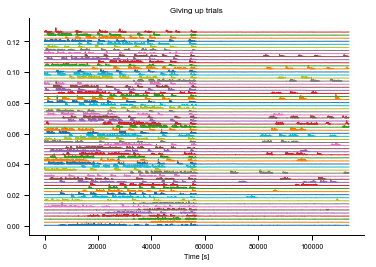

In [287]:
fig, axs = plt.subplots(nrows=1, sharex=True)
window_ep = np.arange((window_im[0]/fs_im) * fs_ep, (window_im[-1]/fs_im) * fs_ep, dtype='int')
x_axis_ep = window_ep / 6000

triggers = gu_inds
trig_ep_gu = triggered_behavior(triggers, window_ep, swims)
scale = .002
axs.plot(trig_ep_gu.T + scale * np.arange(trig_ep_gu.shape[0]))
axs.title.set_text('Giving up trials')
axs.set_xlabel('Time [s]')

In [8]:
import thunder as td
trigger_inds = (frames_gu + window_im.reshape(-1,1)).T.ravel()
ims = td.images.fromlist(np.array(fnames)[trigger_inds], accessor=read_image, engine=sc)

In [9]:
# try first on heavily downsampled data
ims_ds = ims.map(lambda v: downscale_local_mean(v, (1,2,2)))

In [10]:
dims = ims_ds.first().shape

In [11]:
from factorization import ICA

In [12]:
%%time
# generate variance volume. If I saved a boolean mask at calculation of df/f this would not be necessary...
var_vol = ims_ds.toseries().map(lambda v: v.var()).toarray()

CPU times: user 12.6 s, sys: 740 ms, total: 13.4 s
Wall time: 1min 11s


In [13]:
var_vol.reshape(dims).shape

(29, 512, 512)

In [14]:
var_vol_mask = var_vol.reshape(dims) > 0
def recon(v):
    return unfilter_flat(v, var_vol_mask)

In [15]:
#ser_ds = ims_ds.map(lambda v: v.ravel()).toseries().cache()
def demean(v):
    return v - v.mean()
mask_bc = sc.broadcast(var_vol.reshape(dims) > 0)
ser_ds = ims_ds.map(lambda v: filter_flat(v, mask_bc.value)).toseries().map(lambda v: demean(v)).cache()
ser_ds.count()

5198174

In [16]:
%%time
k = 512
result_ica = ICA(k=k, k_pca=k, svd_method='mllib').fit(ser_ds)

CPU times: user 2min 33s, sys: 1min 14s, total: 3min 47s
Wall time: 1h 26min 8s


In [17]:
result_ica[1].shape

(512, 1953)

In [18]:
means = np.array([result_ica[1][c].reshape(len(frames_gu),len(window_im)).mean(0) for c in range(result_ica[1].shape[0])])
order = np.argsort(means.var(1))[::-1]

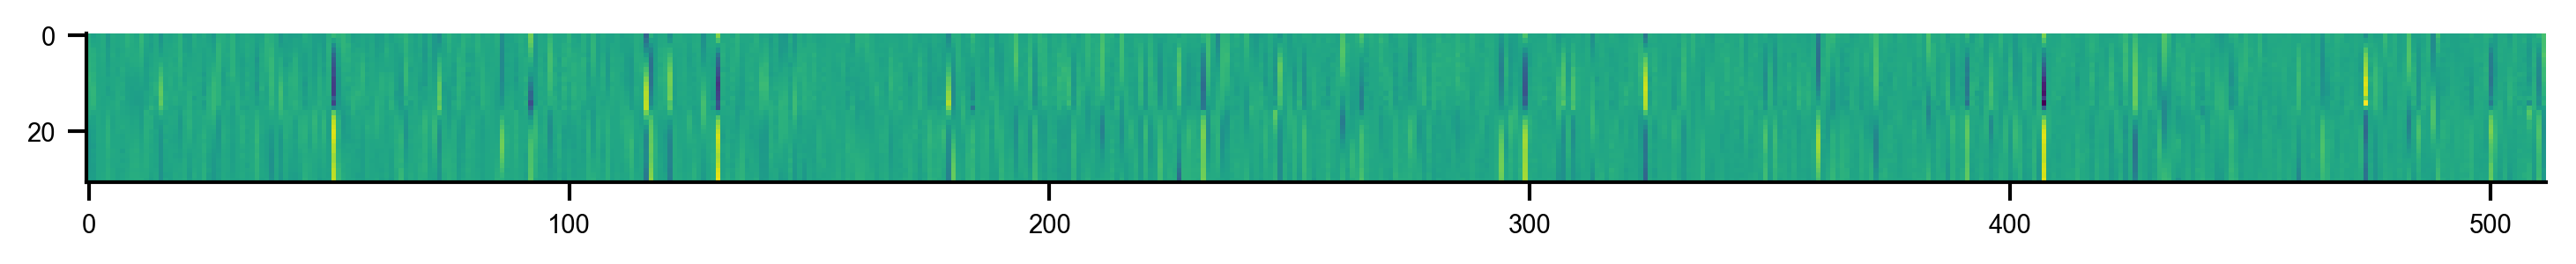

In [19]:
plt.figure(figsize=(12,12), dpi=300)
plt.imshow(means.T, interpolation='None');

In [20]:
from os.path import exists
from os import mkdir
from os import makedirs
result = result_ica
means = np.array([result[1][c].reshape(len(frames_gu),len(window_im)).mean(0) for c in range(result[1].shape[0])])
out_path = '/groups/ahrens/ahrenslab/davis/tmp/tmp_figs_v3/{0}/'.format(exp_name)

if not exists(out_path):
    makedirs(out_path)
    
for ind, cmp in enumerate(order):
    fig, axs = plt.subplots(figsize=(24,8), ncols=3)
    vol_ = recon(result[0][:,cmp])
    axs[0].imshow(my_proj(vol_, np.max, aspect=(5,1,1)), cmap='magma', origin='lower')
    axs[1].imshow(my_proj(vol_, np.min, aspect=(5,1,1)), cmap='magma_r', origin='lower')
    [ax.axis('off') for ax in axs[:2]]
    axs[2].plot(result[1][cmp].reshape(len(frames_gu),len(window_im)).T);
    axs[2].plot(result[1][cmp].reshape(len(frames_gu),len(window_im)).mean(0), 'k', linewidth=3)
    axs[2].axvline(np.where(window_im==0)[0])    
    plt.savefig(out_path + 'cmp_{0}_{1}.pdf'.format(ind, cmp), dpi=500)
    plt.close()

np.savez(out_path + 'ica_results.npz', weights = result[0], components = result[1], mask=var_vol_mask)

In [288]:
# load some components saved to disk
out_path = '/groups/ahrens/ahrenslab/davis/tmp/tmp_figs_v3/{0}/'.format(exp_name)
ica_result = np.load(out_path + 'ica_results.npz')

In [289]:
tr_len = len(window_im)

In [290]:
result = {k: ica_result[k] for k in ica_result.keys()}

In [291]:
def recon(v):
    return unfilter_flat(v, result['mask'])

def flip_comps(comps):
    peak_times = np.argmax(np.abs(comps), axis=1)
    flip_inds = np.zeros_like(peak_times)
    peak_vals = np.array([c[peak_times[ind]] for ind,c in enumerate(comps)])
    flip_inds[peak_vals > 0] = 1
    flip_inds[peak_vals < 0] = -1
    return flip_inds

In [292]:
flip_inds = flip_comps(result['components'])
result['components'][flip_inds < 0] *= -1
result['weights'][:,flip_inds < 0] *= -1

In [373]:
keep = np.argsort(result['components'].var(1))[::-1][:80]

In [374]:
kept = result['components'][keep]

In [375]:
tr_ave = kept.reshape(-1, kept.shape[1] // tr_len, tr_len).mean(1)

In [376]:
tr_ave.shape

(80, 31)

In [377]:
peaktimes = np.argmax(tr_ave, axis=1)
order = np.argsort(peaktimes)

In [378]:
vols = np.array([recon(result['weights'][:,k]) for k in keep])

In [379]:
weight_means = {}
weight_means['glia'] = vols[:,:,:(vols.shape[2] // 2),:].mean((1,2,3))
weight_means['neurons'] = vols[:,:,(vols.shape[2] // 2):,:].mean((1,2,3))

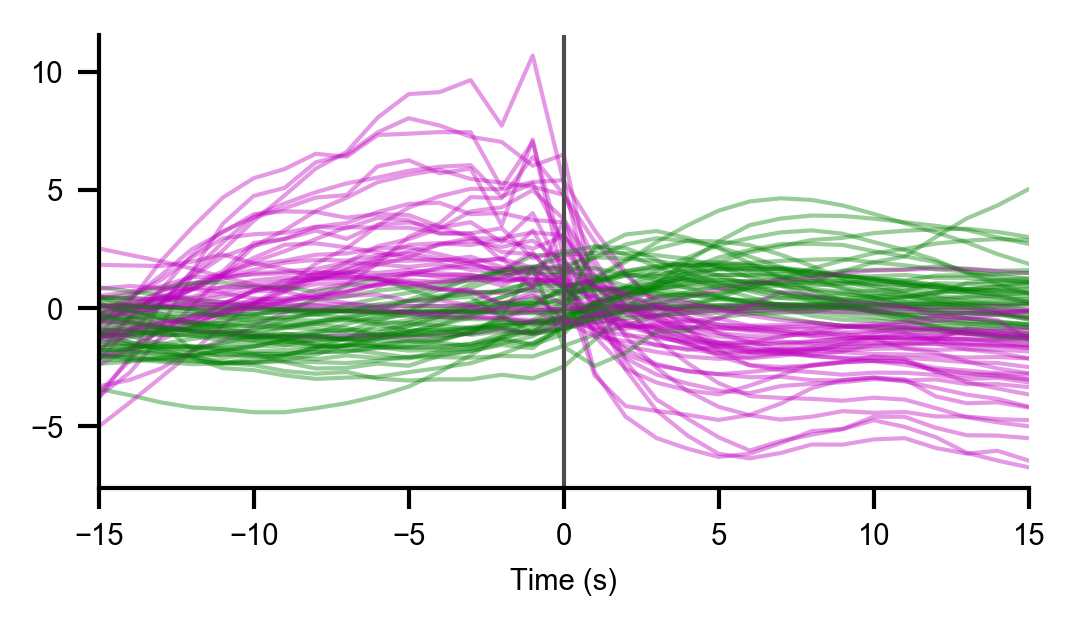

In [380]:
fig, axs = plt.subplots(figsize=(4,2), dpi=300)
for ind, tr in enumerate(tr_ave):
    colors = ['g', 'm']
    if weight_means['glia'][ind] > 0:
        col = colors[0]
    else:
        col= colors[1]
    axs.plot(window_im, tr, color=col, alpha=.4);
axs.set_xlabel('Time (s)')
axs.set_xlim(window_im[0], window_im[-1])
axs.axvline(0, color=[.3,.3,.3])

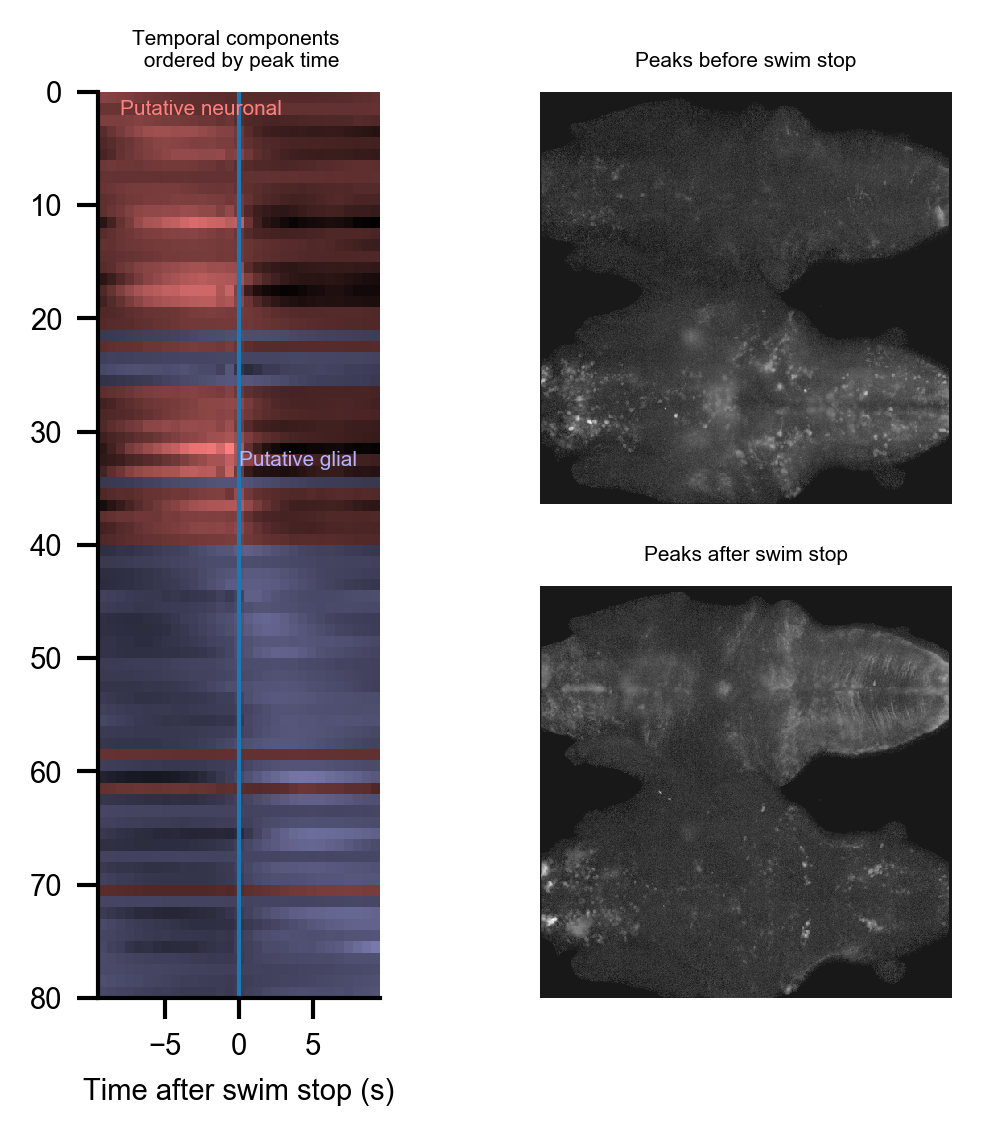

In [381]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity, adjust_gamma
early = peaktimes < 16
late = peaktimes > 16

fig = plt.figure(figsize=(4,4), dpi=300)
gs = plt.GridSpec(2,2, width_ratios=(1,2))
span = fig.add_subplot(gs[:,0])
imaxs = [fig.add_subplot(gs[0,1]), fig.add_subplot(gs[1,1])]

tr_im = gray2rgb(rescale_intensity(tr_ave[order], out_range=(0,1)), alpha=True)
# color by probable cell type for that component

colors = [np.array([.7, .7, 1,1]), np.array([1, .5, .5, 1])]
tr_im[(weight_means['glia'] > 0)[order]] *= colors[0]
tr_im[(weight_means['glia'] < 0)[order]] *= colors[1]
span.imshow(tr_im, extent=(*window_im[[0,-1]] / fs_im, len(order), 0), aspect='auto')
span.axvline(0)
span.title.set_text('Temporal components \n ordered by peak time')
span.text(-8,2,'Putative neuronal', fontsize=5, color = colors[1])
span.text(0,33,'Putative glial', fontsize=5, color = colors[0])
span.set_xlabel('Time after swim stop (s)')
span.title.set_fontsize(5)

imaxs[0].imshow(adjust_gamma(rescale_intensity(vols[early].mean(0).max(0), out_range=(0,1)),.4), cmap='gray')
imaxs[1].imshow(adjust_gamma(rescale_intensity(vols[late].mean(0).max(0), out_range=(0,1)),.4), cmap='gray')
[imax.axis('off') for imax in imaxs]
imaxs[0].title.set_text('Peaks before swim stop')
imaxs[0].title.set_fontsize(5)
imaxs[1].title.set_text('Peaks after swim stop')
imaxs[1].title.set_fontsize(5)

In [382]:
ts = result['components']
from scipy.cluster.hierarchy import dendrogram, linkage
l = linkage(kept, method='complete', optimal_ordering='True')

Text(0,0.5,'component number')

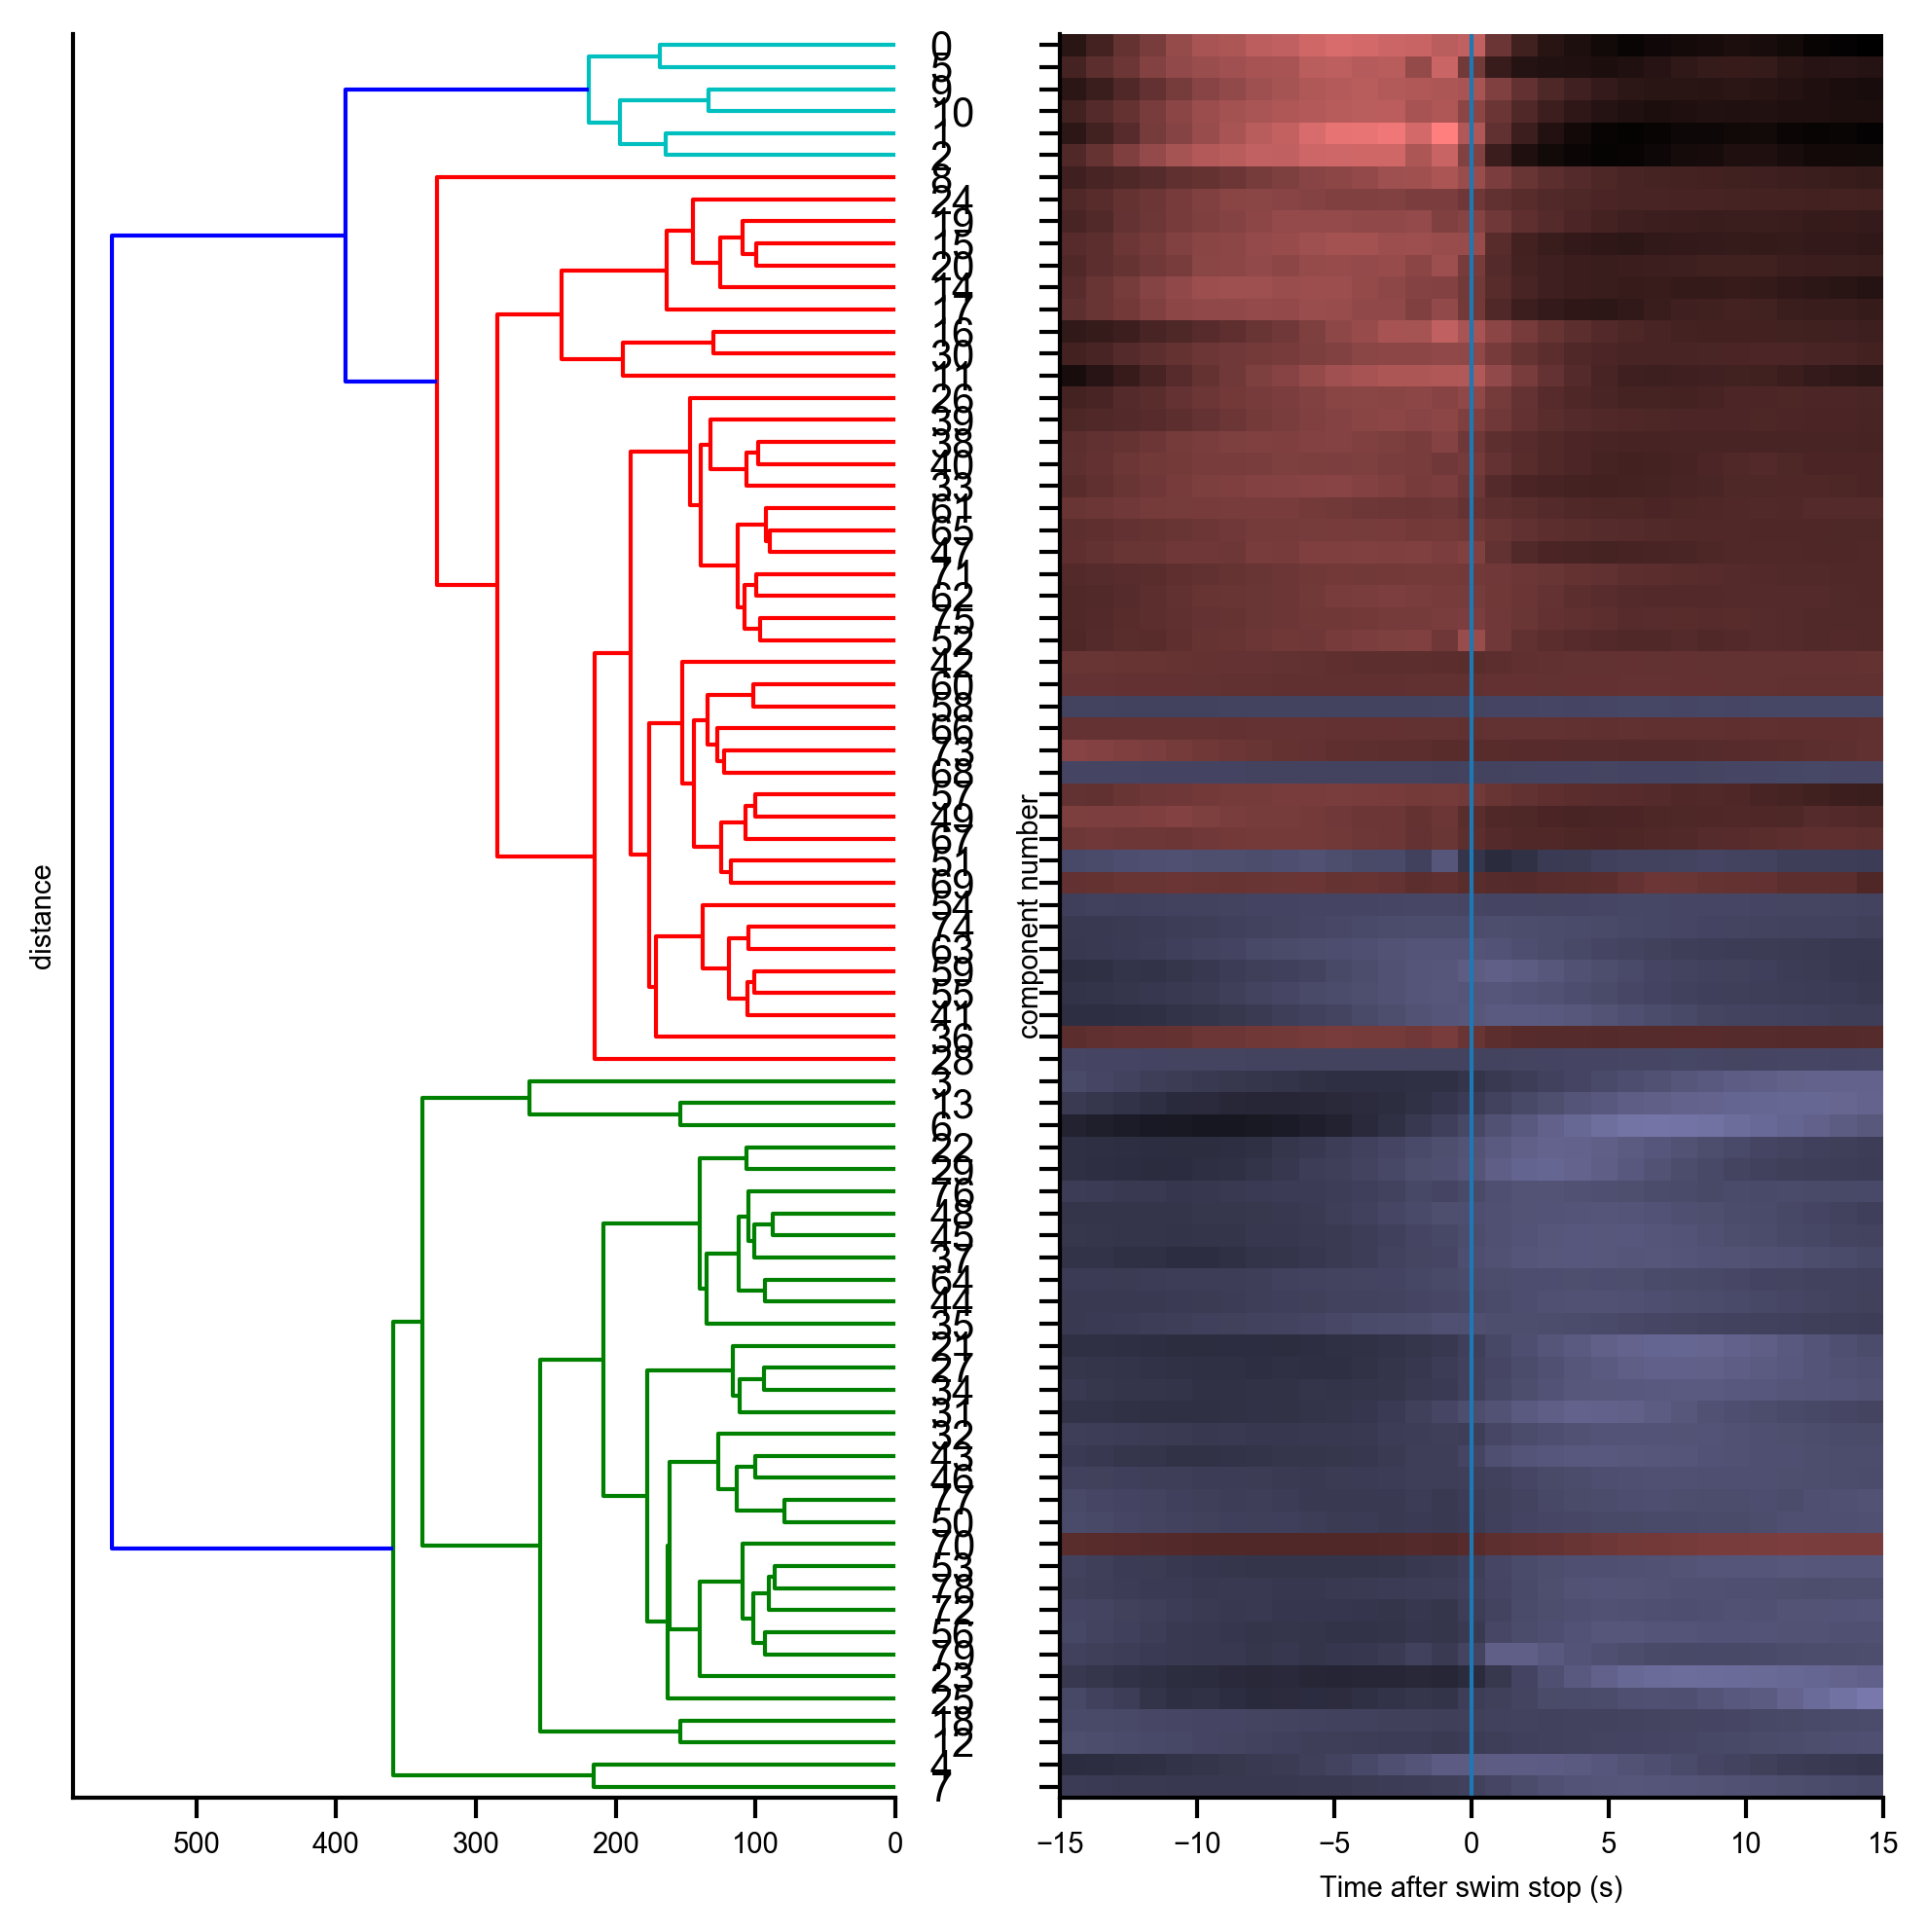

In [383]:
# calculate full dendrogram
fig, axs = plt.subplots(figsize=(8, 8), ncols=2, sharey=True, dpi=300)
axs[0].set_ylabel('distance')
den = dendrogram(
    l,
    ax=axs[0],
    orientation='left',
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10,  # font size for the x axis labels
)
colors = [np.array([.7, .7, 1,1]), np.array([1, .5, .5, 1])]
tr_im = gray2rgb(rescale_intensity(tr_ave, out_range=(0,1)), alpha=True)
tr_im[(weight_means['glia'] > 0)] *= colors[0]
tr_im[(weight_means['glia'] < 0)] *= colors[1]
axs[1].imshow(tr_im[den['leaves']], extent=(*window_im[[0,-1]], *axs[0].get_ylim()), aspect='auto', origin='lower', cmap='gray')
axs[1].set_xlabel('Time after swim stop (s)')
axs[1].axvline(0)
axs[1].set_ylabel('component number')

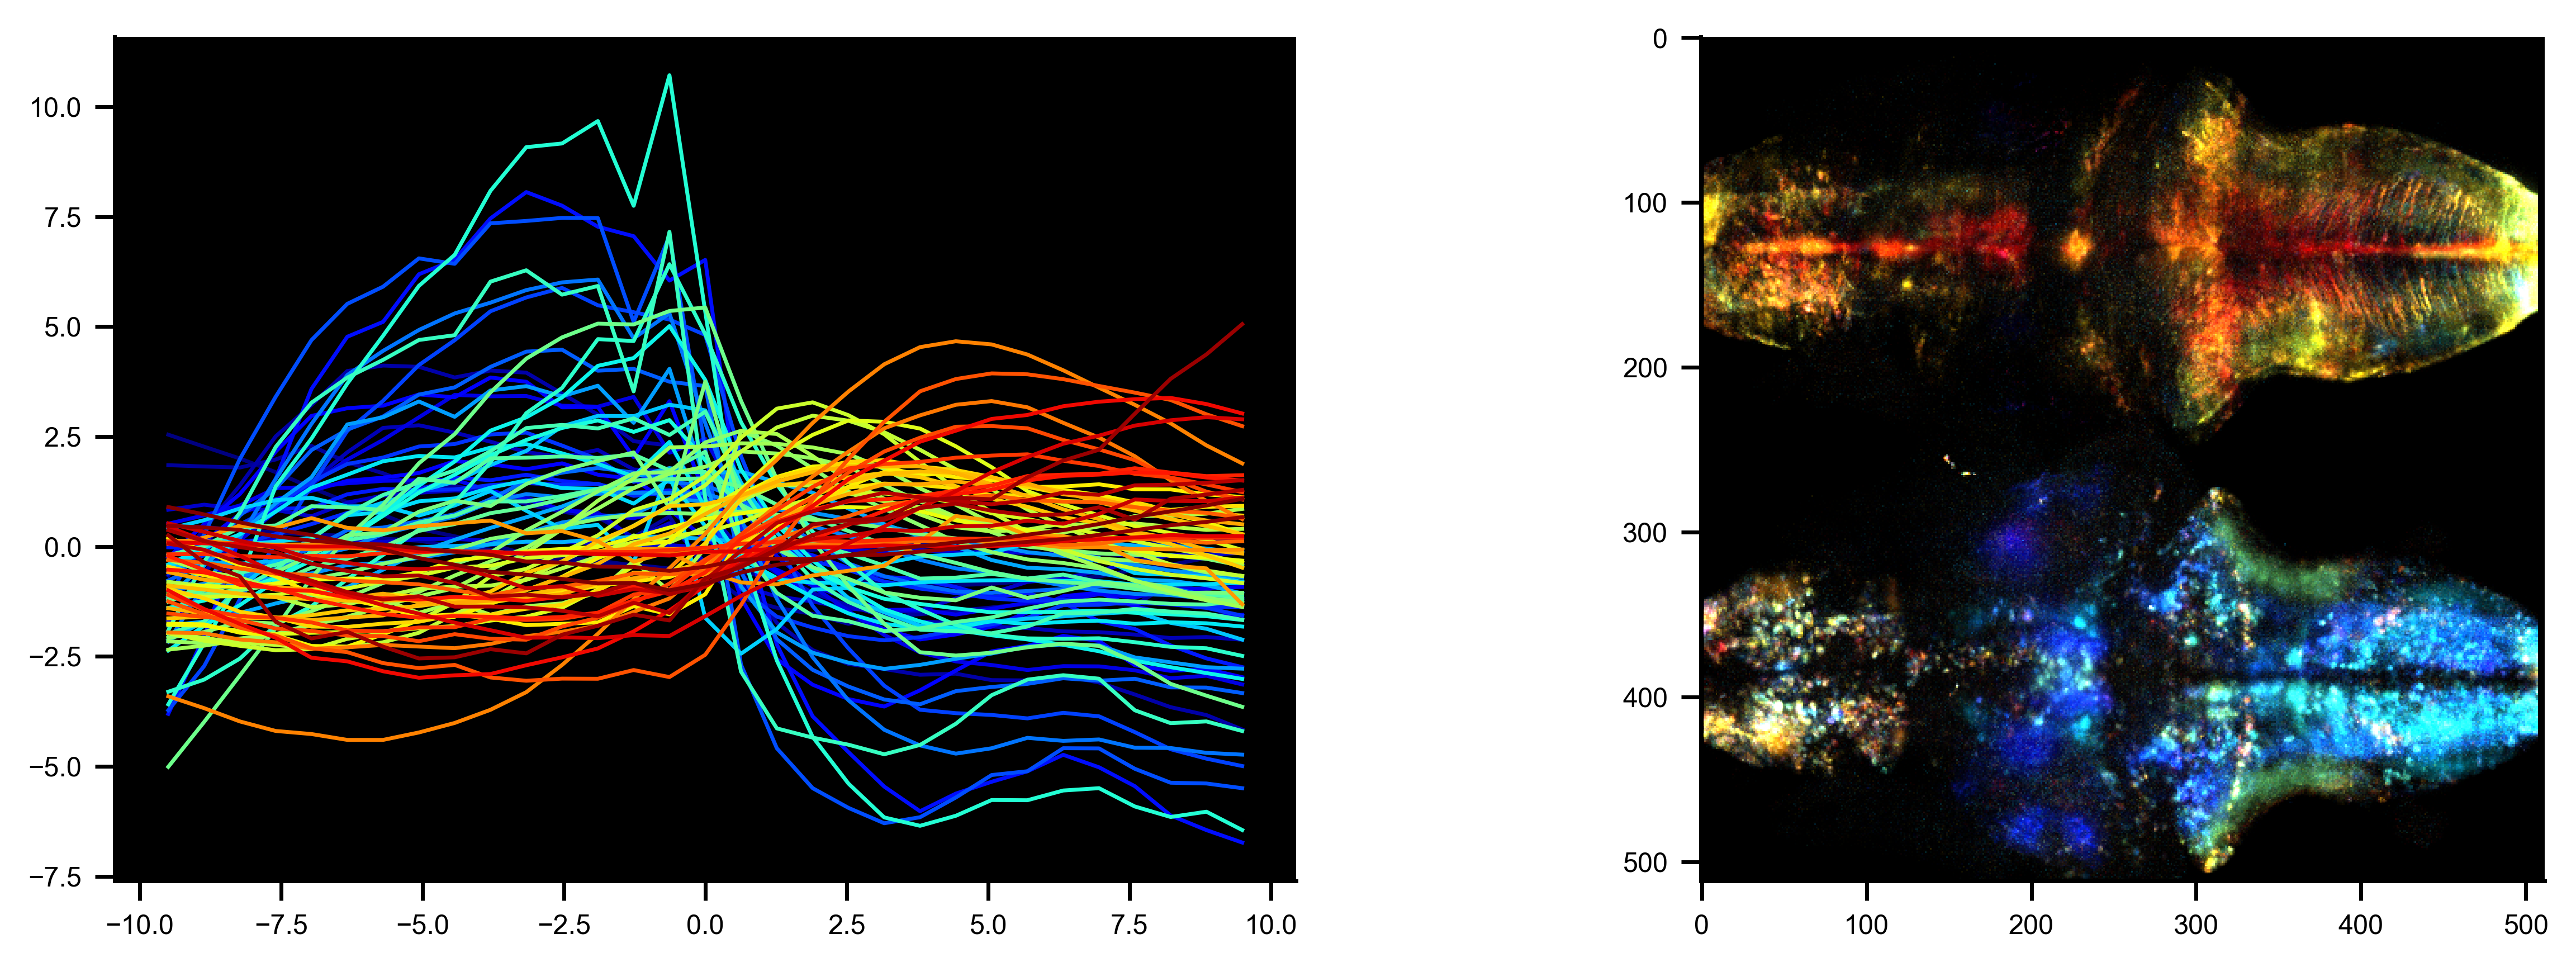

In [413]:
%matplotlib inline
from matplotlib import cm
from skimage.color import gray2rgb
fig, axs = plt.subplots(figsize=(12,4), ncols=2, dpi=500)
#inds = np.array([6,1,4,9,11,12,5,3,8])
#inds = np.array([0,2,7,10,13,15,16,24])
inds= np.array(den['leaves'])
ind_order = np.argsort(np.argmax(tr_ave[inds], axis=1))
cols = [np.array(cm.jet(np.linspace(0, 1, len(inds))[ind]))[:-1] for ind, val in enumerate(inds[ind_order])]
axs[0].set_facecolor('k')
for ind, val in enumerate(inds[ind_order]):
    axs[0].plot(window_im / fs_im, tr_ave[val], label=val, linewidth=1, color=cols[ind]);

vols_c = np.array([gray2rgb(rescale_intensity(v.clip(np.percentile(v, 99), None), out_range=(0,1)).max(0)) for v in vols[inds[ind_order]]])
vols_c = np.array([v * cols[ind] for ind, v in enumerate(vols_c)])
axs[1].imshow(vols_c.sum(0).clip(0,1), cmap='gray')

In [321]:
def simple_thr(data, perc):
    lower, mid = np.percentile(data, [perc, 50])
    thr = mid + (mid - lower)
    return thr

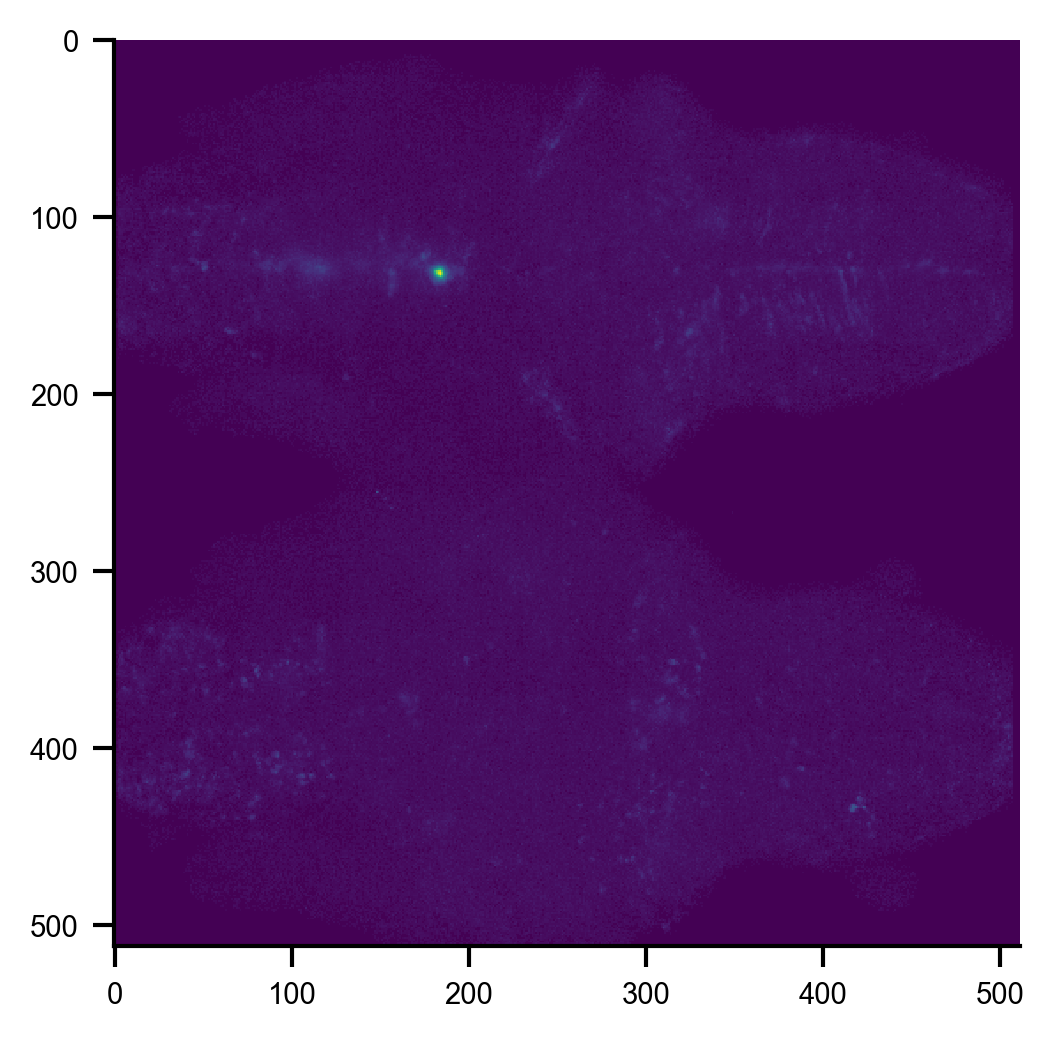

In [448]:
fig, axs = plt.subplots(dpi=300)
cmp = 50
thr = simple_thr(result['weights'][:,keep[cmp]], perc=10)
masked = vols[cmp] > thr
from skimage.morphology import remove_small_objects
axs.imshow((masked).max(0) * vols[cmp].max(0))

In [307]:
result_matrix = np.zeros([3, kept.shape[0], kept.shape[0]])
from scipy.stats import zscore
for ind_y, k_y in enumerate(kept[den['leaves']]):
    for ind_x, k_x in enumerate(kept[den['leaves']]):
        corr = np.correlate(zscore(k_y), zscore(k_x), 'full') / len(k_y)
        result_matrix[0, ind_y, ind_x] = np.corrcoef(k_y, k_x)[0,1]
        result_matrix[1, ind_y, ind_x] = corr.max()
        result_matrix[2, ind_y, ind_x] = np.argmax(corr)

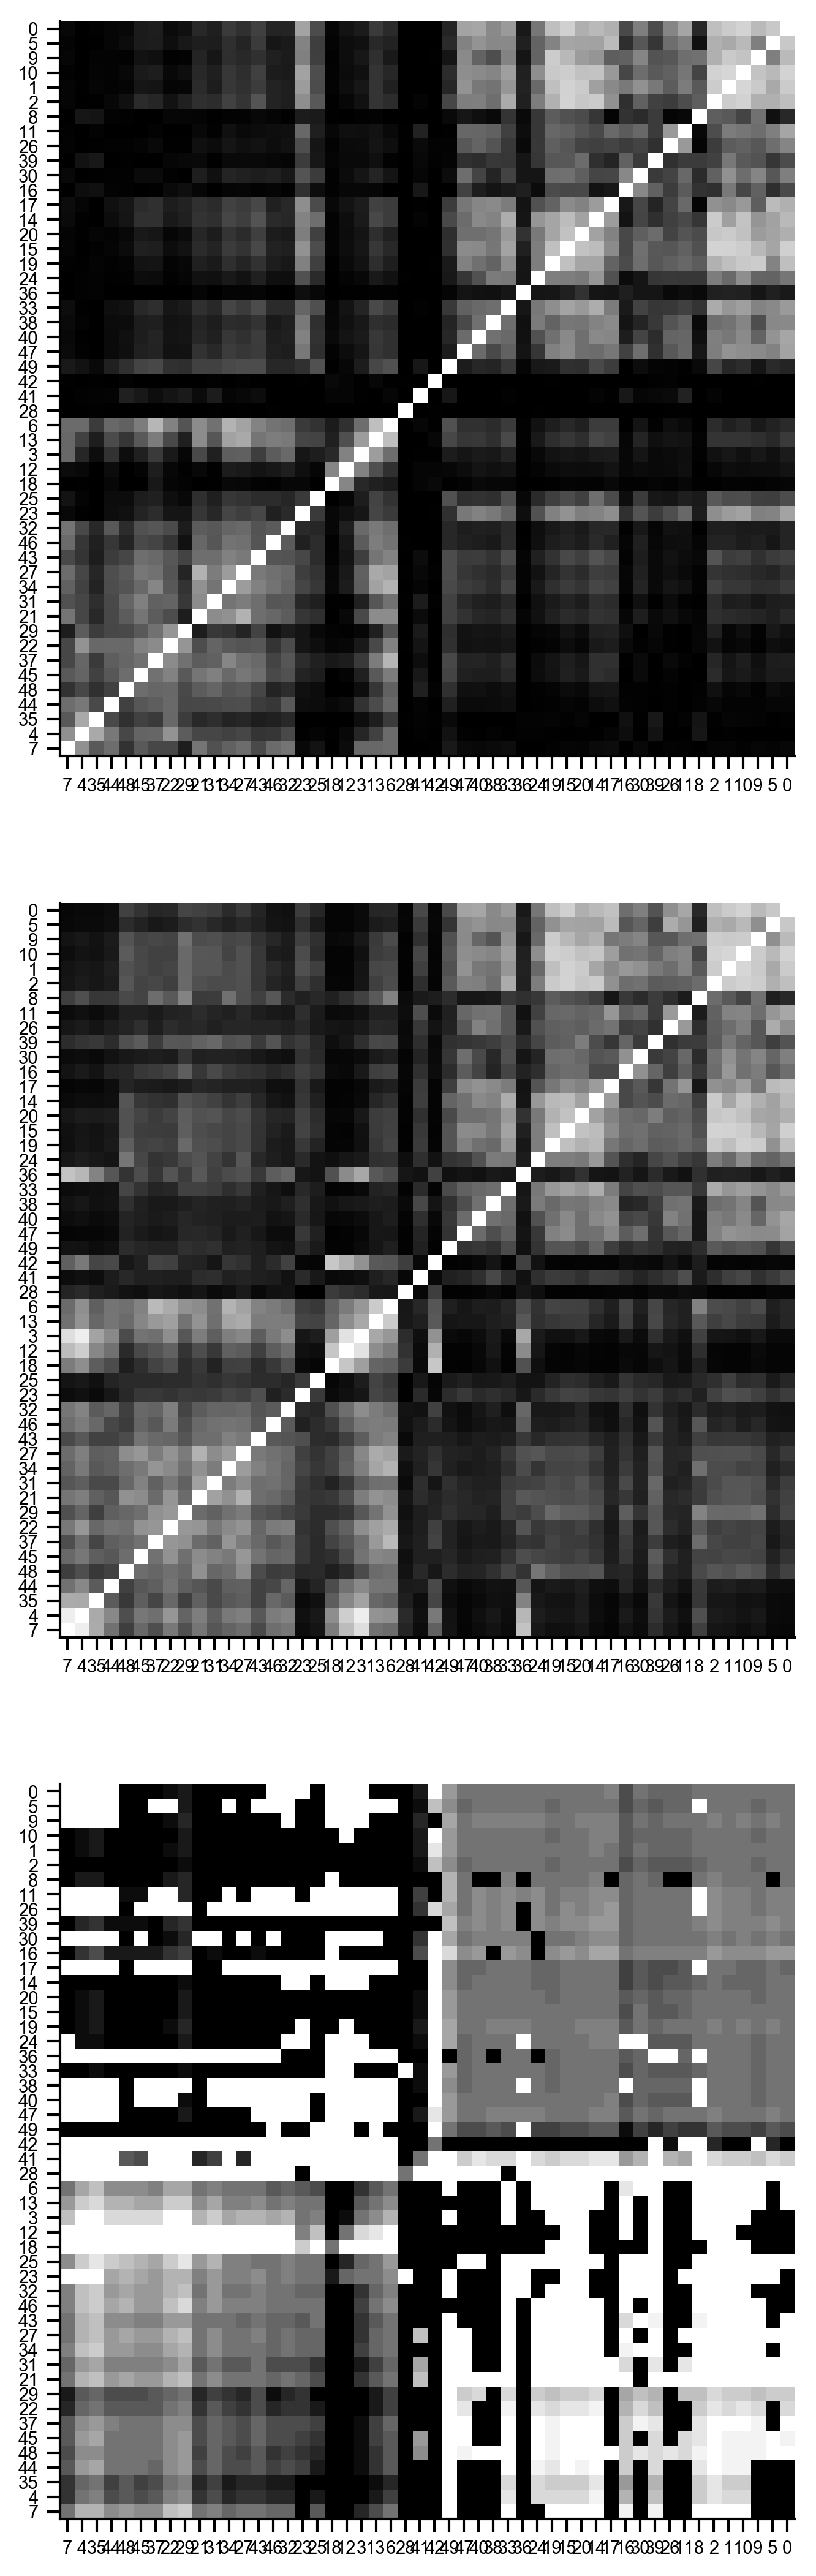

In [308]:
fig, axs= plt.subplots(nrows=3, figsize=(18,18), dpi=300)
axs[0].imshow(result_matrix[0] ** 2, origin='lower', clim=[0,1], cmap='gray')
axs[1].imshow(result_matrix[1] ** 2, origin='lower', clim=[0,1], cmap='gray')
axs[2].imshow(result_matrix[2], origin='lower', clim=[kept.shape[1] - 10, kept.shape[1] + 10], cmap='gray')
[ax.set_yticks(np.arange(result_matrix.shape[1])) for ax in axs];
[ax.set_yticklabels(den['leaves']) for ax in axs];
[ax.set_xticks(np.arange(result_matrix.shape[1])) for ax in axs];
[ax.set_xticklabels(den['leaves']) for ax in axs];